In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

In [ ]:
! pip install -q kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityajn105/flickr8k
! unzip /content/flickr8ksau.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k-sau/Flickr_Data/Images/2844747252_64567cf14a.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2848266893_9693c66275.jpg  


In [ ]:
image_path='/content/Flickr_Data/Images/*'
images=glob(image_path + "*.jpg")
print("Total Images in Dataset = {}".format(len(images)))

Total Images in Dataset = 8091


## Visualize the data

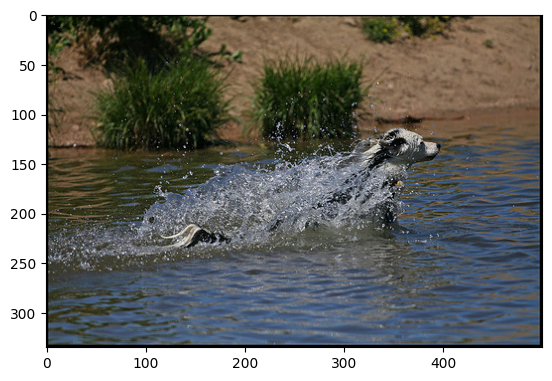

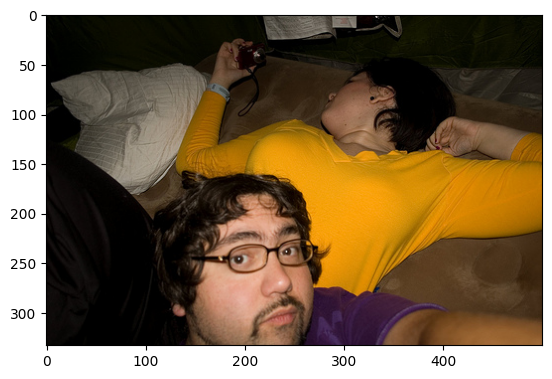

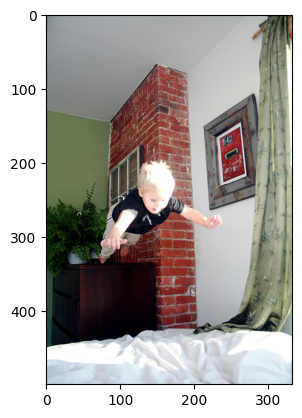

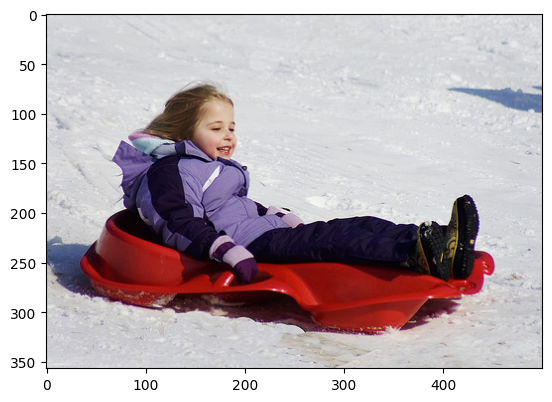

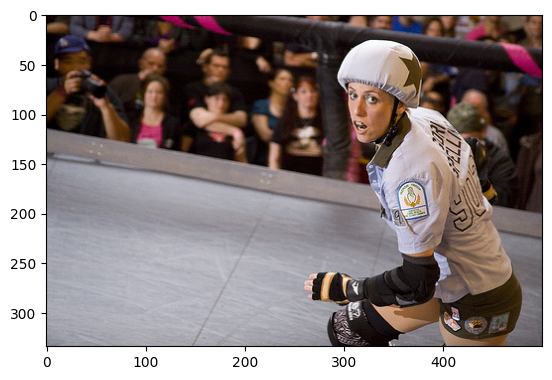

In [ ]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

## Pre-processing the Images:

In [ ]:
from tensorflow.keras.applications import ResNet50

#load vgg16 model
model = ResNet50(include_top=True)
#restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

In [ ]:
#extract features from image
images_folder = '/content/Flickr_Data/Images'
features = {}

for img_name in tqdm(os.listdir(images_folder)):
    #load image from file
    img_path = images_folder + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    #convert image pixels to numpy array
    image = img_to_array(image)
    #reshape data for the model
    image=image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    #preprocess image for VGG
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split('.')[0]
    #store feature
    features[image_id] = feature

100%|██████████| 8091/8091 [10:41<00:00, 12.60it/s]


In [ ]:
import pickle

# Save the features in the images1 pickle file
with open("image_features.pkl", "wb") as encoded_pickle:
    pickle.dump(features, encoded_pickle)

In [ ]:
# Specify the path to your pickle file
picklefile_path = 'image_features.pkl'

# Open the pickle file for reading in binary mode
with open(picklefile_path, 'rb') as file:
    # Load the data from the pickle file
    features = pickle.load(file)

features['2387197355_237f6f41ee']

array([[1.6974242 , 3.4762084 , 0.        , ..., 0.36919606, 0.2910828 ,
        0.5716581 ]], dtype=float32)

## Pre-processing the text data:

In [ ]:
def read_captions(filename):
    with open(filename, 'rb') as f:
        next(f)  # To remove the 1st line "Image, captions"
        cap_doc = f.read().decode('utf-8').split('\n')
    return cap_doc

# Example usage:
file_path = '/content/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
info = read_captions(file_path)
print(info[:10])

['1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .', '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .']


In [ ]:
def load_captions(info):
    dict_1 = dict()
    for line in info:
        parts = line.split(',', 1)  # Split on the first comma to separate image_id and caption
        if len(parts) == 2:
            image_id, caption = parts
            image_id = image_id.strip().split('.')[0]  # Extract the image ID without the file extension

            if image_id not in dict_1:
                dict_1[image_id] = list()

            dict_1[image_id].append(caption)

    return dict_1

data = load_captions(info)
print("Total Images in Dataset = {}".format(len(data)))


# Print the first 2 keys and their values
for i, (image_id, captions) in enumerate(data.items()):
    print(f"Image ID: {image_id}")
    print("Captions:")
    for caption in captions:
        print(f" {caption}")
    print()

    if i == 1:
        break

Total Images in Dataset = 2088
Image ID: 1012212859_01547e3f17
Captions:
  a red ball next to it .
  stands on shore shaking off water

Image ID: 1022454332_6af2c1449a
Captions:
  facing the water and the city skyline .



In [ ]:
# Cleanse and pre-process the data
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]

            # Add startseq at the beginning
            lines += "startseq "

            for j in line1.split():
                if len(j) < 2:
                    continue
                j = j.lower()
                lines += j + " "

            # Add endseq at the end
            lines += "endseq"

            if key not in dict_2:
                dict_2[key] = list()

            dict_2[key].append(lines)

    return dict_2

data2 = cleanse_data(data)
print(len(data2))

# Print the first 2 keys and their values
for i, (image_id, captions) in enumerate(data2.items()):
    print(f"Image ID: {image_id}")
    print("Cleaned Captions:")
    for caption in captions:
        print(f" {caption}")
    print()

    if i == 1:
        break

2088
Image ID: 1012212859_01547e3f17
Cleaned Captions:
 startseq red ball next to it endseq
 startseq stands on shore shaking off water endseq

Image ID: 1022454332_6af2c1449a
Cleaned Captions:
 startseq facing the water and the city skyline endseq



In [ ]:
clean_captions = []
for key in data2:
    for caption in data2[key]:
        clean_captions.append(caption)

len(clean_captions)

2447

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text
tokenizer =  Tokenizer()
tokenizer.fit_on_texts(clean_captions)
vocab_size = len(tokenizer.word_index)+1

#get maximum length of the caption
max_length = max(len(caption.split()) for caption in clean_captions)

max_length

23

In [ ]:
image_ids = list(data2.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]
print(len(train), len(test))

1879 209


In [ ]:
test

['459284240_5a4167bf92',
 '459814265_d48ba48978',
 '460478198_83039f2593',
 '460781612_6815c74d37',
 '460973814_5eacd1ced4',
 '461019788_bc0993dabd',
 '461505235_590102a5bf',
 '462080147_ca088e6541',
 '462198798_89e2df0358',
 '462288558_b31a8a976f',
 '464116251_1ac4bc91f8',
 '466176275_f40d37851e',
 '467960888_6943257534',
 '468102269_135938e209',
 '469617651_278e586e46',
 '470887785_e0b1241d94',
 '470887791_86d5a08a38',
 '470903027_489cc507de',
 '472661386_723aae880b',
 '475313618_bdb2f72be5',
 '476233374_e1396998ef',
 '476740978_45b65ebe0c',
 '478208896_90e7187b64',
 '478209058_21e2c37c73',
 '478592803_f57cc9c461',
 '479807115_3a484fb18b',
 '480200554_6155e9dfeb',
 '481632457_7372f18275',
 '481732592_b50194cb89',
 '482830610_13a0a6c924',
 '483039719_75181b2726',
 '483136916_16976f4902',
 '485738889_c2a00876a6',
 '486300784_2cc7a770ff',
 '488089932_c3a5fa4140',
 '488196964_49159f11fd',
 '488356951_b3b77ad832',
 '488408004_a1e26d4886',
 '488549693_a1f51d8c4a',
 '489551372_b19a6ad0ed',


## Creating Our Data Loader:

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, data2, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n=0
    while(1):
        for key in data_keys:
            n+=1
            captions = data2[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq=tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 23)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 23, 256)              536320    ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_4[0][0]']             
                                                                                            

In [ ]:
# train the model
epochs =50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, data2, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

58/58 [==============================] - 7s 123ms/step - loss: 0.2830 - accuracy: 0.9178


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = data2[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 209/209 [02:06<00:00,  1.65it/s]

BLEU-1: 0.296524
BLEU-2: 0.090262


In [ ]:
# from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    captions = data2[image_id]
    print('---------------------Actual----------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

In [ ]:
generate_caption('1000268201_693b08cb0e.jpg')

KeyError: ignored

In [ ]:
def beam_search(photo,k):
    photo=photo.reshape(1,2048)
    in_text='<start>'
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    predicted=[]
    y_pred=y_pred.reshape(-1)
    for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
    predicted=sorted(predicted,key=lambda x:x[1])[::-1]
    b_search=[]
    for i in range(k):
        word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))

    for idx in range(max_length):
        b_search_square=[]
        for text in b_search:
            if text[0].split(" ")[-1]=="<end>":
                break
            sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
            sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
            y_pred = model.predict([photo,sequence],verbose=0)
            predicted=[]
            y_pred=y_pred.reshape(-1)
            for i in range(y_pred.shape[0]):
                predicted.append((i,y_pred[i]))
                predicted=sorted(predicted,key=lambda x:x[1])[::-1]
            for i in range(k):
                word = indices_to_words[predicted[i][0]]
                b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
        if(len(b_search_square)>0):
            b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
    final=b_search[0][0].split()
    final = final[1:-1]
    #final=" ".join(final)
    return final

In [ ]:
id_mapping = {image_id: image_id for image_id in data2.keys()}

test_features = {id_mapping[image_id]: features[image_id] for image_id in test}

In [ ]:
i=0
for img_id in test_features:
    i+=1
    img=cv2.imread("/Users/shalinitandon/Desktop/Fall Sem 3/CS 583/Image Captioning/Dataset/Filckr8k/Images/" + img_id)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    photo=test_features[img_id]
    plt.show()
    reference=[]
    for caps in test_captions[img_id]:
        list_caps=caps.split(" ")
        list_caps=list_caps[1:-1]
        reference.append(list_caps)
    candidate=beam_search(photo,3)
    score = sentence_bleu(reference, candidate)
    print("Referance Captions: ")
    for cap in reference:
        print(" ".join(cap))
    print("Predicted Caption: ")
    print(" ".join(candidate))
    print("bleu score: ",score)
    if(i==5):
        break